In [1]:
# Загрузка пакетов
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy.stats import t
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Константы
my_seed = 10  # номер варианта

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Функция для графиков сжатия коэффициентов
def plot_coeffs_traces(X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    colors = sns.color_palette("Spectral", len(col_names))

    weights, params = [], []
    # Используем np.linspace вместо np.arange для вещественных чисел
    c_values = np.linspace(C_min_pow, C_max_pow, int(C_max_pow - C_min_pow) * 5 + 1)

    for c in c_values:
        lr = LogisticRegression(penalty=penalty_name, C=10.0**c, solver='liblinear',
                               multi_class='ovr', random_state=my_seed, max_iter=1000)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10.0**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column], label=col_names[column], color=color)

    plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=2, label='Optimal C')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('Weight Coefficient')
    plt.xlabel('C (1/λ)')
    plt.xscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.title(f'Lasso Coefficients Trajectory - Class {class_number}')
    plt.tight_layout()
    plt.show()

In [2]:
# Загрузка данных
# Предполагаем, что данные уже загружены как DF_all
# winequality-red_for_lab
DF_all = pd.read_csv('https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/winequality-red_for_lab.csv')

# Оставляем только Y и все переменные кроме quality и Y
X_columns = [col for col in DF_all.columns if col not in ['quality', 'Y']]
DF_all = DF_all[['Y'] + X_columns]

# Разделение на обучающую и отложенную выборку
DF = DF_all.sample(frac=0.85, random_state=my_seed)
DF_predict = DF_all.drop(DF.index)

print('Размер обучающей выборки:', DF.shape)
print('Размер отложенной выборки:', DF_predict.shape)
print('\nПервые 5 строк обучающей выборки:')
print(DF.head())

Размер обучающей выборки: (1359, 12)
Размер отложенной выборки: (240, 12)

Первые 5 строк обучающей выборки:
      Y  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
1518  0            7.4              0.47         0.46             2.2   
1246  0            7.4              0.74         0.07             1.7   
544   1           14.3              0.31         0.74             1.8   
1343  1            7.5              0.51         0.02             1.7   
428   0            9.1              0.52         0.33             1.3   

      chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    pH  \
1518      0.114                  7.0                  20.0  0.99647  3.32   
1246      0.086                 15.0                  48.0  0.99502  3.12   
544       0.075                  6.0                  15.0  1.00080  2.86   
1343      0.084                 13.0                  31.0  0.99538  3.36   
428       0.070                  9.0                  30.0  0.99780

Пропуски в данных:
Y                       0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Доли классов:
Y
1    0.525
0    0.475
Name: count, dtype: float64

Описательные статистики:
                 Y  fixed_acidity  volatile_acidity  citric_acid  \
count  1359.000000    1359.000000       1359.000000  1359.000000   
mean      0.524650       8.282561          0.528503     0.268506   
std       0.499576       1.716960          0.178512     0.193256   
min       0.000000       4.600000          0.120000     0.000000   
25%       0.000000       7.100000          0.400000     0.090000   
50%       1.000000       7.900000          0.520000     0.250000   
75%       1.000000       9.200000          0.640000     0.420000   
max       1.000000 

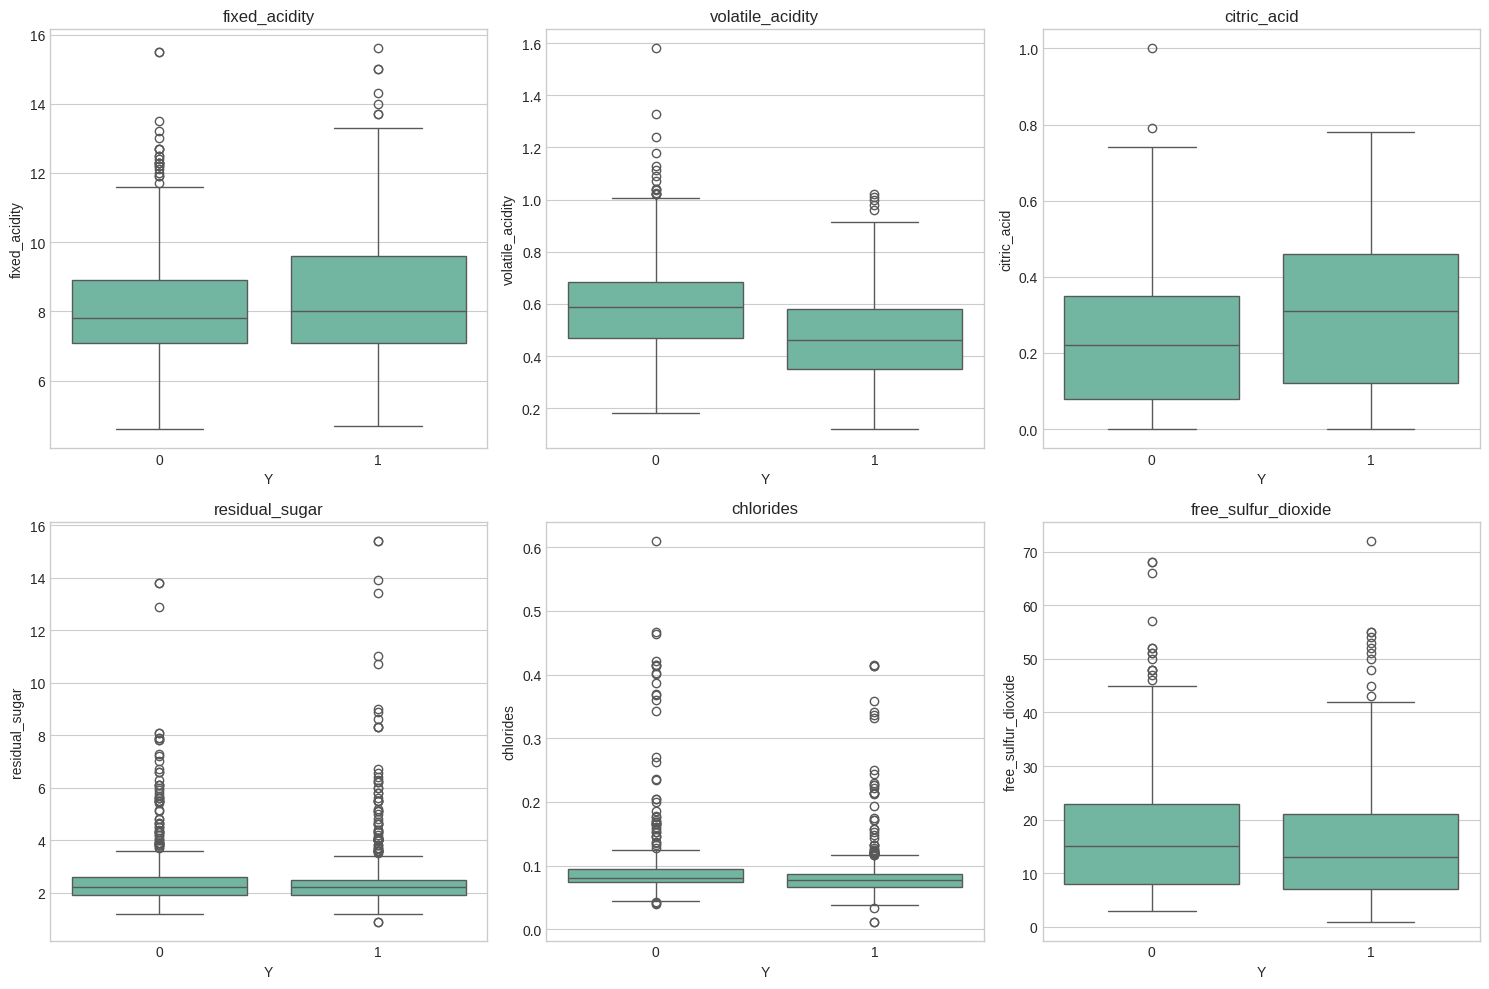

In [3]:
# Пропуски
print('Пропуски в данных:')
print(DF.isna().sum())

# Доли классов
print('\nДоли классов:')
print(np.around(DF.Y.value_counts() / len(DF.index), 3))

# Описательные статистики
print('\nОписательные статистики:')
print(DF.describe())

# Визуализация разброса переменных
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(X_columns[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Y', y=col, data=DF)
    plt.title(col)
plt.tight_layout()
plt.show()

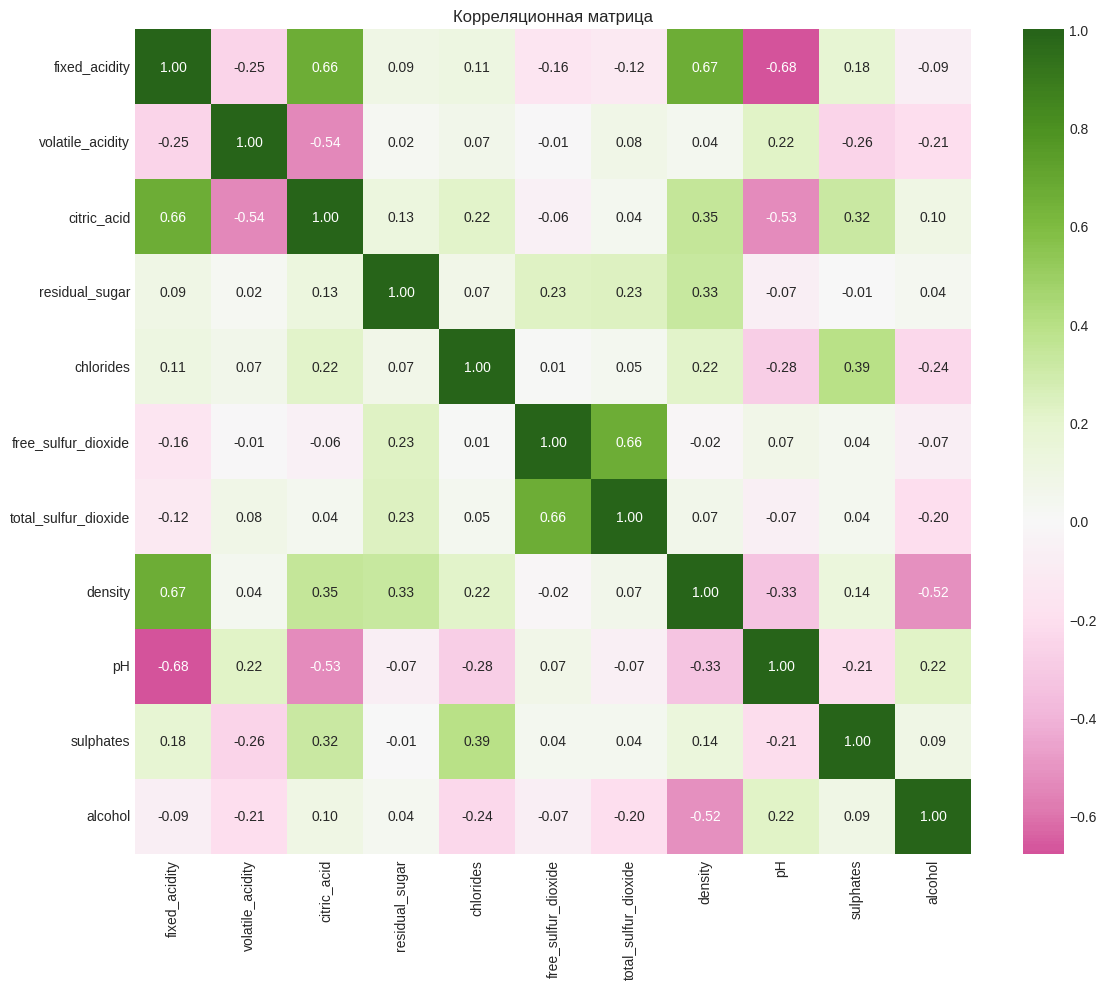

Значимые корреляции (p < 0.05):
           Показатель_1          Показатель_2  Корреляция  P_значение
6         fixed_acidity               density    0.666692         0.0
1         fixed_acidity           citric_acid    0.662050         0.0
40  free_sulfur_dioxide  total_sulfur_dioxide    0.660152         0.0
38            chlorides             sulphates    0.393209         0.0
23          citric_acid               density    0.350206         0.0
30       residual_sugar               density    0.334845         0.0
25          citric_acid             sulphates    0.322122         0.0
29       residual_sugar  total_sulfur_dioxide    0.234806         0.0
28       residual_sugar   free_sulfur_dioxide    0.226755         0.0
16     volatile_acidity                    pH    0.224684         0.0


In [4]:
# Корреляционный анализ
corr_mat = DF[X_columns].corr()

# Тепловая карта корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, annot=True, cmap='PiYG', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

# Значимые корреляции
df_corr = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
df_corr = df_corr.stack().reset_index()
df_corr.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']

# p-значения
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df_corr.Корреляция.values ** 2))
df_corr['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))

print('Значимые корреляции (p < 0.05):')
print(df_corr.loc[df_corr['P_значение'] < 0.05].sort_values('Корреляция', ascending=False).head(10))

Доли объяснённой дисперсии по компонентам в PLS:
[0.161 0.129 0.12  0.096 0.071 0.038 0.044 0.065 0.034 0.012 0.028]
Накопленная доля: [0.161 0.29  0.41  0.506 0.577 0.615 0.659 0.724 0.758 0.771 0.799]


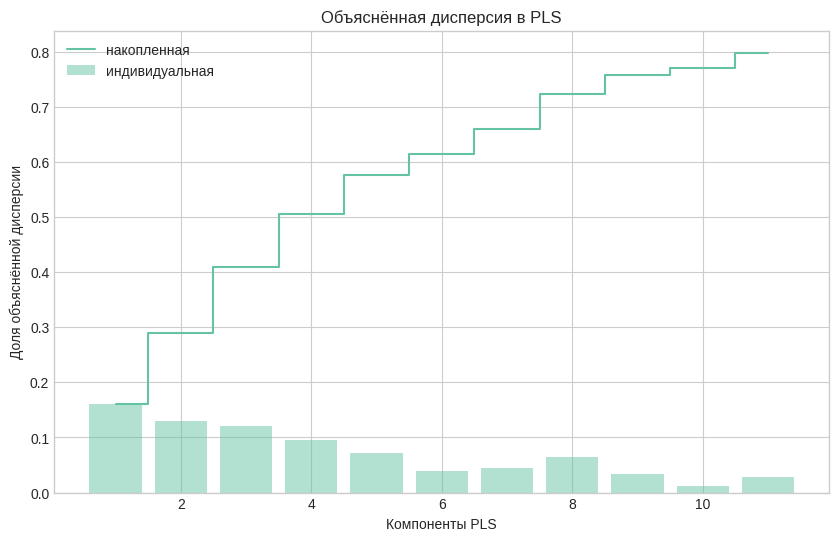


PLS + логистическая регрессия
Средняя точность по 10 блокам: 0.737
Стандартное отклонение: 0.027


In [5]:
# Стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF[X_columns].values)
Y_train = DF.Y.values

# Метод PLS со всеми компонентами
pls_full = PLSRegression(n_components=len(X_columns))
pls_full.fit(X_train_std, Y_train)

# Доли объяснённой дисперсии
x_scores_var = np.var(pls_full.x_scores_, axis=0)
total_var = np.var(X_train_std, axis=0).sum()
frac_var_expl = x_scores_var / total_var

print('Доли объяснённой дисперсии по компонентам в PLS:')
print(np.around(frac_var_expl, 3))
print('Накопленная доля:', np.around(np.cumsum(frac_var_expl), 3))

# График объяснённой дисперсии
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(frac_var_expl)+1), frac_var_expl, alpha=0.5, align='center', label='индивидуальная')
plt.step(range(1, len(frac_var_expl)+1), np.cumsum(frac_var_expl), where='mid', label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Компоненты PLS')
plt.legend()
plt.title('Объяснённая дисперсия в PLS')
plt.show()


n_components = 5
pls = PLSRegression(n_components=n_components)
pls.fit(X_train_std, Y_train)
X_train_pls = pls.transform(X_train_std)

# Логистическая регрессия на PLS компонентах
logit_pls = LogisticRegression(random_state=my_seed)
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)

# Перекрёстная проверка вручную для PLS
acc_blocks_pls = []
for train_index, test_index in kf_10.split(X_train_std):
    # Данные для блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train[train_index]
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # PLS преобразование
    pls_block = PLSRegression(n_components=n_components)
    pls_block.fit(X_i_train, Y_i_train)
    X_i_train_pls = pls_block.transform(X_i_train)
    X_i_test_pls = pls_block.transform(X_i_test)

    # Логистическая регрессия
    logit_block = LogisticRegression(random_state=my_seed)
    logit_block.fit(X_i_train_pls, Y_i_train)
    Y_pred = logit_block.predict(X_i_test_pls)

    acc = accuracy_score(Y_i_test, Y_pred)
    acc_blocks_pls.append(acc)

acc_pls = np.mean(acc_blocks_pls)
print(f'\nPLS + логистическая регрессия')
print(f'Средняя точность по 10 блокам: {acc_pls:.3f}')
print(f'Стандартное отклонение: {np.std(acc_blocks_pls):.3f}')

4. РЕГУЛЯРИЗАЦИЯ МЕТОДОМ ЛАССО-РЕГРЕССИИ
Подбор оптимального параметра C для лассо-регрессии...
Оптимальные значения C: [21.5443469]
Точность лассо-регрессии на обучающей выборке: 0.741
Лассо-регрессия (перекрестная проверка): 0.732 ± 0.034

Коэффициенты лассо-регрессии:
                Variable  Coefficient
10               alcohol       0.9423
1       volatile_acidity      -0.6427
6   total_sulfur_dioxide      -0.4956
9              sulphates       0.4463
2            citric_acid      -0.2606
0          fixed_acidity       0.2498
5    free_sulfur_dioxide       0.1750
4              chlorides      -0.1662
3         residual_sugar       0.1159
7                density      -0.0872
8                     pH      -0.0575

Количество обнуленных коэффициентов: 0

Построение графиков сжатия коэффициентов...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

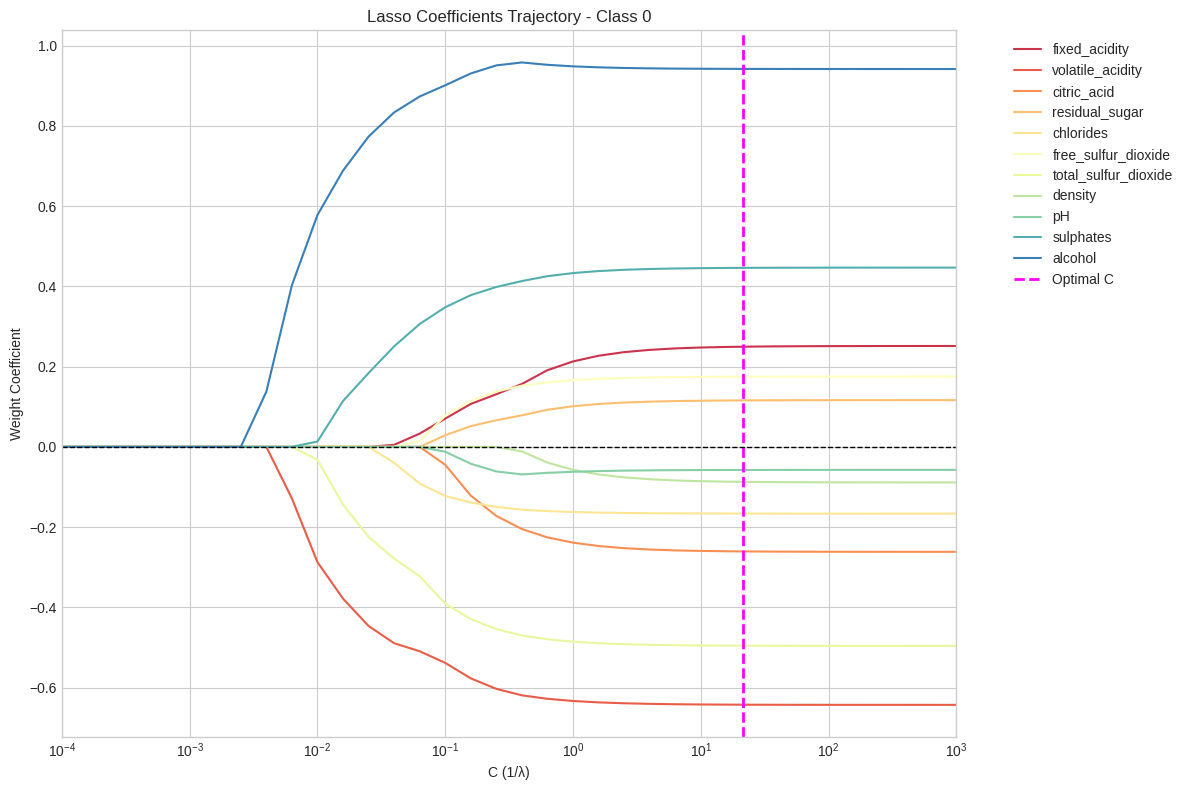

In [6]:
# 4. Регуляризация методом лассо-регрессии

# Подбор оптимального гиперпараметра C для лассо-регрессии
print("=" * 60)
print("4. РЕГУЛЯРИЗАЦИЯ МЕТОДОМ ЛАССО-РЕГРЕССИИ")
print("=" * 60)

print("Подбор оптимального параметра C для лассо-регрессии...")
lasso_cv = LogisticRegressionCV(
    cv=10,
    random_state=my_seed,
    penalty='l1',
    solver='liblinear',
    scoring='accuracy',
    max_iter=1000
)
lasso_cv.fit(X_train_std, Y_train)

print(f'Оптимальные значения C: {lasso_cv.C_}')

# Оценка точности лассо-регрессии
acc_lasso_train = lasso_cv.score(X_train_std, Y_train)
print(f'Точность лассо-регрессии на обучающей выборке: {acc_lasso_train:.3f}')

# Перекрестная проверка для лассо
lasso_scores = cross_val_score(lasso_cv, X_train_std, Y_train, cv=kf_10, scoring='accuracy')
acc_lasso_cv = lasso_scores.mean()
print(f'Лассо-регрессия (перекрестная проверка): {acc_lasso_cv:.3f} ± {lasso_scores.std():.3f}')

# Коэффициенты модели
print('\nКоэффициенты лассо-регрессии:')
coef_df = pd.DataFrame({
    'Variable': X_columns,
    'Coefficient': lasso_cv.coef_[0],
    'Abs_Coefficient': np.abs(lasso_cv.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(coef_df.drop('Abs_Coefficient', axis=1).round(4))

# Анализ обнуленных коэффициентов
zero_coef = coef_df[coef_df['Coefficient'] == 0]
print(f'\nКоличество обнуленных коэффициентов: {len(zero_coef)}')
if len(zero_coef) > 0:
    print("Обнуленные переменные:")
    print(zero_coef['Variable'].tolist())

# Графики сжатия коэффициентов
print('\nПостроение графиков сжатия коэффициентов...')
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, X_columns)

In [7]:
pls_final = PLSRegression(n_components=n_components)
pls_final.fit(X_train_std, Y_train)
X_train_pls_final = pls_final.transform(X_train_std)

logit_pls_final = LogisticRegression(random_state=my_seed)
logit_pls_final.fit(X_train_pls_final, Y_train)

models_comparison = pd.DataFrame({
    'Модель': ['PLS + логистическая регрессия', 'Лассо-регрессия'],
    'Accuracy_CV': [acc_pls, acc_lasso_cv],
    'Std_CV': [np.std(acc_blocks_pls), lasso_scores.std()],
    'Accuracy_Train': [logit_pls_final.score(X_train_pls_final, Y_train), acc_lasso_train]
})

print(models_comparison.round(3))

best_model_idx = models_comparison['Accuracy_CV'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Модель']
best_accuracy = models_comparison.loc[best_model_idx, 'Accuracy_CV']


X_test_std = sc.transform(DF_predict[X_columns].values)
y_test_true = DF_predict['Y'].values


                          Модель  Accuracy_CV  Std_CV  Accuracy_Train
0  PLS + логистическая регрессия        0.737   0.027           0.745
1                Лассо-регрессия        0.732   0.034           0.741


In [8]:
DF = DF_all.sample(frac=0.85, random_state=10)
DF_predict = DF_all.drop(DF.index)

print(f"Обучающая выборка: {DF.shape}")
print(f"Отложенная выборка: {DF_predict.shape}")

Обучающая выборка: (1359, 12)
Отложенная выборка: (240, 12)


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

# Дерево классификации
X = DF[X_columns]
y = DF['Y']

# Поиск оптимального параметра обрезки
param_grid = {'ccp_alpha': np.linspace(0, 0.02, 50)}
tree = DecisionTreeClassifier(random_state=10)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print(f"Оптимальное значение ccp_alpha: {grid_search.best_params_['ccp_alpha']:.4f}")
print(f"Точность дерева с обрезкой: {grid_search.best_score_:.3f}")

best_tree = grid_search.best_estimator_

Оптимальное значение ccp_alpha: 0.0000
Точность дерева с обрезкой: 0.721


In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Более разумные параметры для поиска
param_grid = {
    'n_estimators': [30, 50, 70],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0]
}

bagging = BaggingClassifier(random_state=10)
grid_search_bag = GridSearchCV(bagging, param_grid, cv=3, scoring='accuracy', n_jobs=-1)  # cv=3 и n_jobs=-1
grid_search_bag.fit(X, y)

print("Оптимальные параметры бэггинга:")
print(f"n_estimators: {grid_search_bag.best_params_['n_estimators']}")
print(f"max_samples: {grid_search_bag.best_params_['max_samples']}")
print(f"max_features: {grid_search_bag.best_params_['max_features']}")
print(f"Точность бэггинга: {grid_search_bag.best_score_:.3f}")

best_bagging = grid_search_bag.best_estimator_

Оптимальные параметры бэггинга:
n_estimators: 30
max_samples: 0.6
max_features: 0.6
Точность бэггинга: 0.792


In [11]:
# Сравнение точности моделей
tree_score = grid_search.best_score_
bagging_score = grid_search_bag.best_score_

print(f"Точность дерева с обрезкой: {tree_score:.3f}")
print(f"Точность бэггинга: {bagging_score:.3f}")

if bagging_score > tree_score:
    best_model = best_bagging
    best_model_name = "Бэггинг"
    print("Лучшая модель: Бэггинг")
else:
    best_model = best_tree
    best_model_name = "Дерево с обрезкой"
    print("Лучшая модель: Дерево с обрезкой")

Точность дерева с обрезкой: 0.721
Точность бэггинга: 0.792
Лучшая модель: Бэггинг


In [12]:
from sklearn.metrics import classification_report, accuracy_score

# Прогноз на отложенных данных
X_test = DF_predict[X_columns]
y_test = DF_predict['Y']

y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Точность на отложенных наблюдениях: {test_accuracy:.3f}")
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))

Точность на отложенных наблюдениях: 0.792

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        98
           1       0.85      0.79      0.82       142

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.80      0.79      0.79       240



In [13]:
# Точности моделей из упражнения 3 (примерные значения)
pls_accuracy = 0.737  # PLS + логистическая регрессия
lasso_accuracy = 0.732  # Лассо-регрессия

print("Сравнение с моделями из упражнения 3:")
print(f"PLS + логистическая регрессия: {pls_accuracy:.3f}")
print(f"Лассо-регрессия: {lasso_accuracy:.3f}")
print(f"Лучшая модель из упражнения 4 ({best_model_name}): {test_accuracy:.3f}")

if test_accuracy > max(pls_accuracy, lasso_accuracy):
    print("Модель из упражнения 4 показала лучшую точность")
else:
    print("Модели из упражнения 3 показали лучшую точность")

Сравнение с моделями из упражнения 3:
PLS + логистическая регрессия: 0.737
Лассо-регрессия: 0.732
Лучшая модель из упражнения 4 (Бэггинг): 0.792
Модель из упражнения 4 показала лучшую точность
